## Microbenchmarks

Adapted from https://github.com/TheSalon/fast-dpsgd/blob/main/results/runtimes.ipynb

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)

In [2]:
RAW = 'raw'
RUNS = 10
REPEATS = 10

## Data Preprocessing

In [3]:
layers = ['mha', 'rnn', 'gru', 'lstm']
names = ['conv', 'layernorm', 'instancenorm', 'groupnorm', 'linear', 'embedding', 'mha', 'rnn', 'gru', 'lstm']
gsm_names = ['gsm_' + name if name not in layers else 'gsm_dp' + name for name in names]
batch_sizes = [16, 32, 64, 128, 256, 512]

In [4]:
def generate_df(names):
    
    def expt_iterator(names):
        for name in names:
            for bs in batch_sizes:
                yield name, bs
    files = []
    success, errors = 0, 0
    for name, bs in expt_iterator(names):
        pickle_name = f'./{RAW}/{name}_bs_{bs}_runs_{RUNS}_repeats_{REPEATS}'

        with open(pickle_name+'.pkl', 'rb') as f:
            d = pickle.load(f)
            assert(len(d['runtime']) == RUNS)
            assert(len(d['memory']) == RUNS)

        files.append((name, bs, d))
        
    print(success, errors)

    df_list = []
    for *row, d in files:
        d = d['runtime'] + d['memory']
        df_list.append(pd.Series(row + d))

    df = pd.concat(df_list, axis=1).transpose()
    df.columns = ['Layer', 'Batch Size'] + [f'Runtime {i}' for i in range(REPEATS)] + [f'Memory {i}' for i in range(REPEATS)]
    return df

In [5]:
nn = generate_df(names)
opacus = generate_df(gsm_names)

0 0
0 0


In [6]:
factors = nn.copy()

for item in ['Runtime', 'Memory']:
    for i in range(REPEATS):
        factors[f"{item} {i}"] =  opacus[f"{item} {i}"] / factors[f"{item} {i}"] 
    factors['nans'] = factors.isnull().sum(axis=1)

    factors[f'Median {item}'] = factors[[f'{item} {i}' for i in range(REPEATS)]].median(axis = 1)
    factors[f'Std {item}'] = factors[[f'{item} {i}' for i in range(REPEATS)]].std(axis = 1)
    factors[f'Std% {item}'] = factors[f'Std {item}'] / factors[f'Median {item}'] * 100

df = factors[['Layer', 'Batch Size', 'Median Runtime', 'Std Runtime', 'Std% Runtime', 'Median Memory', 'Std Memory', 'Std% Memory','nans']].copy()

In [7]:
df['Order'] = -1
for i,name in enumerate(names):
    df.loc[df['Layer'] == name, 'Order'] = i
assert not (df['Order'] == -1).sum()
df = df.sort_values(by=['Batch Size', 'Order'])
df

,Layer,Batch Size,Median Runtime,Std Runtime,Std% Runtime,Median Memory,Std Memory,Std% Memory,nans,Order
0,conv,16,2.333971,0.007945,0.340414,1.038087,0.360899,34.765721,0,0
6,layernorm,16,1.999534,0.024303,1.215417,1.000032,0.000172,0.017188,0,1
12,instancenorm,16,1.838888,0.013795,0.750199,0.992369,0.004836,0.487286,0,2
18,groupnorm,16,2.048787,0.025175,1.228780,0.936858,0.000690,0.073664,0,3
24,linear,16,3.205461,0.639389,19.946875,284.773620,178.449503,62.663636,0,4
30,embedding,16,5.281182,1.328889,25.162724,4.218678,1.426089,33.804159,0,5
36,mha,16,2.061313,0.135859,6.590906,1.017784,0.007944,0.780471,0,6
42,rnn,16,15.782673,0.398157,2.522748,0.915743,0.014686,1.603710,0,7
48,gru,16,16.853365,0.533353,3.164668,0.334365,0.043712,13.073231,0,8
54,lstm,16,15.366750,0.341778,2.224137,1.057133,0.154271,14.593347,0,9


In [8]:
def get_runtime_plot(ax, item, ylim=None, figsize=(13, 6)): 
    sns.set_style("whitegrid")
    plot_df = df.copy()
    if ylim:
        plot_df['Median Runtime'] = np.minimum(plot_df['Median Runtime'], ylim-(ylim*0.09))
        plot_df['Median Memory'] = np.minimum(plot_df['Median Memory'], ylim-(ylim*0.09))
        
    sns.barplot(
        x='Layer',
        y=f'Median {item}',
        hue='Batch Size',
        data=plot_df,
        ax=ax,
        palette="Blues"
    )

    tmp = df[f'Median {item}']
    for i, (rect, tim) in enumerate(zip(ax.patches, tmp)):
        
        width = rect.get_width()
        rect.set_width(width-(width*0.15))
        
        height = rect.get_height()
        if tim > 100.:
            annotation = f'{int(tim)}'
        elif tim > 0.:
            annotation = f'{tim:.2g}'
        else:
            annotation = ''
        
        ax.annotate(
            annotation,
            xy=(rect.get_x() + rect.get_width() / 2 - 0.3*rect.get_width(), height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            va='bottom', ha='left', 
            fontsize=9, 
            rotation=45
        )

    plt.title('')
    if item == 'Runtime':
        ax.set_title('Median factor of slowdown from adding DP')
        ax.set_ylabel('Factor slowdown')
    else:
        ax.set_title('Median factor of memory increase from adding DP')
        ax.set_ylabel('Factor memory increase')
           
    ax.set_xlabel('Layer')
    if ylim:
        ax.set_ylim(0, ylim)
    ax.get_legend().remove()
    sns.despine()
    ax.legend()
    f.patch.set_facecolor('white')
    f.tight_layout()
    return f, ax

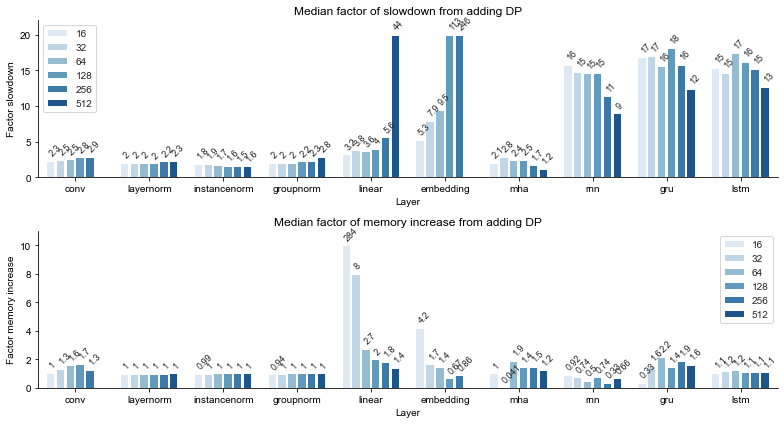

In [9]:
f, ax = plt.subplots(2, 1, figsize=(11, 6), sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'Runtime', 22)
f, ax1 = get_runtime_plot(ax[1], 'Memory', 11)